In [1]:
import tensorflow as tf
import numpy as np
from PIL import Image
from pathlib import Path
import os
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
#Loading images from data
PATH = "C:/Users/Lenovo/Desktop/AI/AI_Project/data/"
data_dir = Path(PATH)
image_num = len(list(data_dir.glob('*/*/*.jpg')))

In [5]:
image_num


5110

In [6]:
image_csv = pd.read_csv(PATH+'Raw_Data_JPG.csv')
CLASS_NAME = image_csv.Diagnosis.unique()

In [7]:
CLASS_NAME

array(['No Finding', 'TB', 'Heart', 'CA lung', 'Intra', 'Extra'],
      dtype=object)

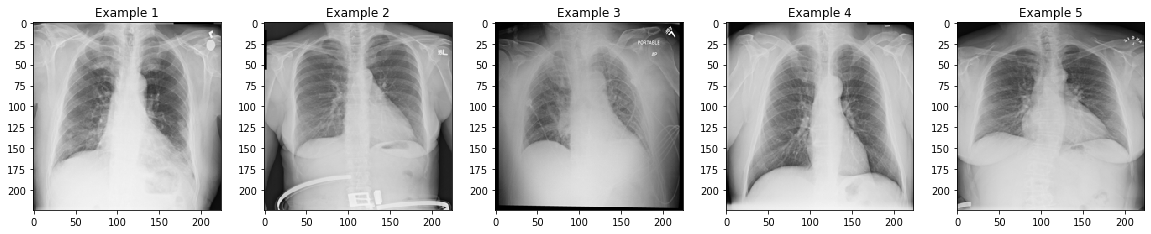

In [22]:
example_NoF = list(data_dir.glob('train/No Finding/*.jpg'))
i = 1
plt.figure(figsize=(20,20))
for n in example_NoF[:5]:
    ex = Image.open(n)
    ex_ar = np.asarray(ex)
    plt.subplot(5,5,i)
    word = "Example "+ str(i)
    plt.title(word)
    plt.imshow(ex_ar)
    i+=1

In [23]:
#Preproccsing image data into ImageDataGenerator
my_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
BATCH_SIZE = 32
IMG_WIDTH = 224
IMG_HEIGHT = 224
STEP_PER_EPOCH = np.ceil(image_num/BATCH_SIZE)

TRAIN_PATH = PATH + "/train/"
TEST_PATH = PATH + "/test/"

In [25]:
#This will be my train_set . 
data_gen_train = my_generator.flow_from_directory(directory=TRAIN_PATH,batch_size=BATCH_SIZE,shuffle=True,target_size=(IMG_HEIGHT,IMG_WIDTH),classes = list(CLASS_NAME))

Found 4088 images belonging to 6 classes.


In [26]:
img_batch,label_batch = next(data_gen_train)

In [27]:
data_gen_test = my_generator.flow_from_directory(directory=TEST_PATH,batch_size=BATCH_SIZE,shuffle=True,target_size=(IMG_HEIGHT,IMG_WIDTH),classes = list(CLASS_NAME))

Found 1022 images belonging to 6 classes.


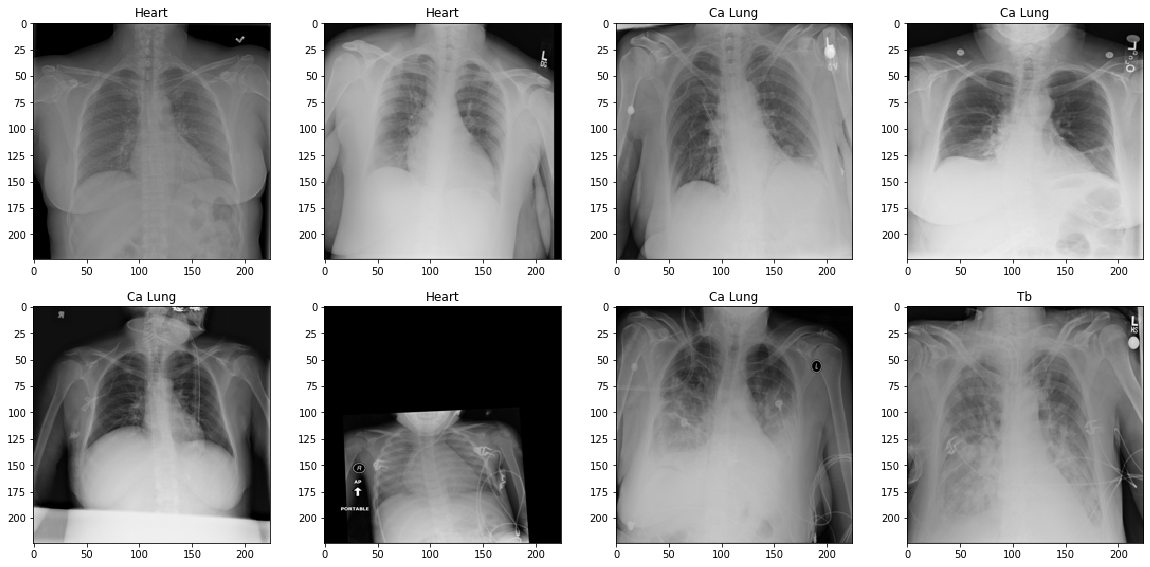

In [28]:
plt.figure(figsize=(20,20))
for n in range(8):
    plt.subplot(4,4,n+1)
    plt.title(CLASS_NAME[label_batch[n]==1][0].title())
    plt.imshow(img_batch[n])

In [29]:
#Try to load InceptionV3
myInception = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet',input_shape=(224,224,3),classes=6)

In [34]:
#myInception.summary()
myInception.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
myInception.fit_generator(data_gen_train,steps_per_epoch=STEP_PER_EPOCH,epochs=10,validation_data=data_gen_test,validation_steps=5,verbose=1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 160.0 steps, validate for 5 steps
Epoch 1/10
